# [cutoffs_and_troughs](https://github.com/ahijevyc/cutoffs_and_troughs) repo

In [1]:
import logging
import os
import pdb
from functools import partial
from pathlib import Path

import cartopy
import matplotlib.animation
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
from utils import (
    animate,
    fmt,
    get_contains_zmin,
    get_location,
    getobs,
    label_id,
    loc2color,
    na_values,
    tissot,
)

sns.set_theme(style="whitegrid")
logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)

In [2]:
Lupo_cases_Table2 = (
    "20160123",
    "20160427",
    "20170315",
    "20180310",
    "20190203",
    "20190529",
    "20191031",
    "20200411",
    "20200902",
    "20200908",
)

In [3]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"

# set extent
lon0 = 360 - 127
lon1 = 360 - 68
lat0 = 23
lat1 = 50
extent = (lon0, lon1, lat0, lat1)

itime = pd.to_datetime("2020030100", format="%Y%m%d%H")

logging.info(f"itime={itime}")

isensemble = False
# Choose a forecast length (24, 48, 72, or 240 work)
forecast_length = 72

datepos = 0
cases = sorted(casedir.glob(f"[12]?????????.F{forecast_length:03d}.C768"))
if isensemble:
    forecast_length = (pd.to_datetime("20200413T12") - itime) / pd.to_timedelta(1, "hour")
    forecast_length = int(forecast_length)
    cases = sorted(casedir.glob(f"E[12]?????????.p??.F{forecast_length:03d}.C768"))
    datepos = 1
itimes = [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in cases]
print(f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}")


pd.Series(itimes, name="itime")

found 24 itimes with 72-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


0    2019-10-23 06:00:00
1    2019-11-24 06:00:00
2    2019-12-20 00:00:00
3    2020-02-09 06:00:00
4    2020-02-20 12:00:00
5    2020-03-01 00:00:00
6    2020-04-06 12:00:00
7    2020-04-09 12:00:00
8    2020-05-16 12:00:00
9    2020-08-29 18:00:00
10   2020-09-07 00:00:00
11   2020-10-25 18:00:00
12   2020-11-25 06:00:00
13   2021-03-14 18:00:00
14   2021-04-09 00:00:00
15   2021-04-11 12:00:00
16   2021-04-28 06:00:00
17   2021-10-16 18:00:00
18   2021-10-26 06:00:00
19   2021-12-31 06:00:00
20   2022-02-13 12:00:00
21   2022-04-11 06:00:00
22   2022-05-02 12:00:00
23   2022-06-11 18:00:00
Name: itime, dtype: datetime64[ns]

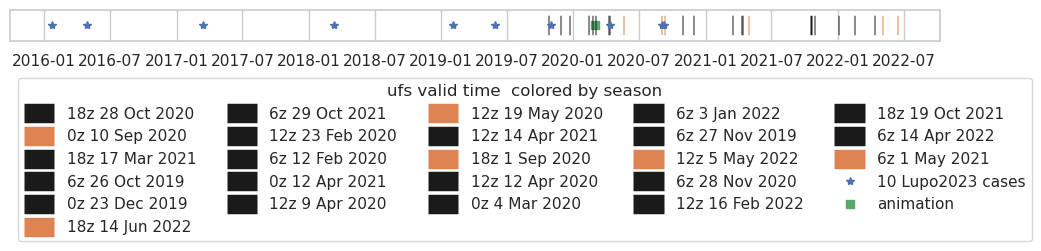

In [4]:
fig, ax = plt.subplots(figsize=(12, 0.4))
ax.plot()
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
lw = 14
for t in set(itimes):
    color = "k"
    vtime = t + forecast_length * pd.Timedelta(hours=1)
    if vtime.month >= 5 and vtime.month <= 9:
        color = "C1"  # element in axes color prop cycler
    ax.hlines(0, t, vtime, label=vtime.strftime("%-Hz %-d %b %Y"), color=color, lw=lw)
ax.plot(
    [pd.to_datetime(d) for d in Lupo_cases_Table2],
    [0.00] * len(Lupo_cases_Table2),
    "*",
    label=f"{len(Lupo_cases_Table2)} Lupo2023 cases",
)
ax.plot(
    itime,
    0.00,
    "s",
    label="animation",
    zorder=0,
    color="C2",
)
ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, -0.96),
    title="ufs valid time  colored by season",
    ncol=5,
)

<li>grey ellipse = analyzed feature at valid time (2020-04-10 18 UTC).
<li>green = forecast feature with big zonal forecast error that we are focusing on
<li>orange = other forecast feature in CONUS area not matched to the feature that we are focusing on
<li>blue = other forecast feature outside of CONUS area
<li>matching black symbols = forecast features sharing the same connection to an analyzed feature. A straight colored line connects them to analyzed feature.
<li>colored circles = location of geopotential height minimum inside the feature indicating a cutoff low, as opposed to a trough.


2020-03-01 00:00:00.2020-03-01 00:00:00.2020-03-01 06:00:00.2020-03-01 12:00:00.2020-03-01 18:00:00.2020-03-02 00:00:00.2020-03-02 06:00:00.2020-03-02 12:00:00.2020-03-02 18:00:00.2020-03-03 00:00:00.2020-03-03 06:00:00.2020-03-03 12:00:00.2020-03-03 18:00:00.2020-03-04 00:00:00.

2020-03-01 00:00:00.

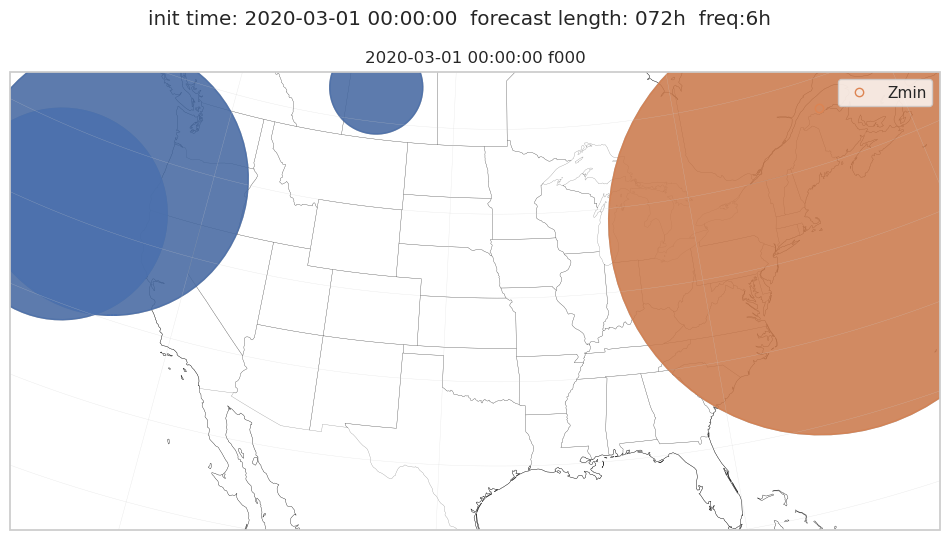

In [5]:
# Choose one of the initializations of itimes.
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": cartopy.crs.LambertConformal()},
)
ax.set_extent(extent)
coastlines = ax.coastlines(lw=0.25)
gridlines = ax.gridlines(lw=0.25, alpha=0.5)
ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)
func = partial(
    animate,
    ax=ax,
    itime=itime,
    workdir=workdir,
    forecast_length=forecast_length,
    isensemble=isensemble,
    extent=extent,
)

freq = "6h"
suptitle = f"init time: {itime}  forecast length: {forecast_length:03d}h  freq:{freq}"
fig.suptitle(suptitle)
valid_times = pd.date_range(start=itime, end=itime + pd.Timedelta(hours=forecast_length), freq=freq)
ani = matplotlib.animation.FuncAnimation(fig, func, frames=valid_times)

HTML(ani.to_jshtml())

## Analyze all track files, regardless of forecast length

In [6]:
files = workdir.glob("[12]?????????.F???.C768/diag_TroughsCutoffs.??????????.f???.track")
if isensemble:
    files = workdir.glob("E[12]?????????.p??.*/diag_TroughsCutoffs.??????????.f???.track")
files = list(files)  # convert generator to list
logging.warning(f"{len(files)} files")

df = pd.concat(
    [
        pd.read_csv(
            f,
            header=0,
            sep=r"\s+",
            na_values=na_values,
        )
        for f in files
    ],
    ignore_index=True,
)

df["location"] = get_location(df, extent)
df["color"] = df["location"].map(loc2color)
df["contains_zmin"] = get_contains_zmin(df)
df["FHOUR"] = df["FHOUR"].str.lstrip("f").astype(float)
df["ITIME"] = pd.to_datetime(df["ITIME"], format="%Y%m%d%H")
df["FDAY"] = (df["FHOUR"] / 24).astype(int)
df["feature"] = "trough"
df.loc[df["contains_zmin"], "feature"] = "cutoff low"
# Divide NH zonal error into terciles (3 equal-sized groups based on value)
df["FERRX"] = pd.qcut(df["FERRX(km)"], 3, labels=["low", "med", "high"])
# df = df[df["FHOUR"] <= 96]
df.color.unique()

2025-04-02 17:36:21,515 1632 files


array(['C0', 'C1', 'C2'], dtype=object)

In [7]:
df["location"].unique()

array(['any', 'CONUS', 'Lupo2023'], dtype=object)

In [8]:
df["So(m/100km)"].describe()

count    61459.000000
mean        18.334215
std          7.169960
min         10.000000
25%         13.410000
50%         16.950000
75%         21.375000
max        128.100000
Name: So(m/100km), dtype: float64

In [9]:
def fix_axes(fp):
    axes = np.atleast_1d(fp.axes)
    lim = (-900, 900)
    for ax in axes.ravel():
        ax.grid(alpha=0.5)
        if ax.get_xlabel().endswith("(N)"):
            ax.set_xlim((-90, 90))
        if ax.get_ylabel().endswith("(N)"):
            ax.set_ylim((-90, 90))
        if ax.get_xlabel().endswith("(E)"):
            ax.set_xlim((0, 360))
        if ax.get_ylabel().endswith("(E)"):
            ax.set_ylim((0, 360))
        if ax.get_xlabel().endswith("(km)"):
            ax.set_xlim(*lim)
        if ax.get_ylabel().endswith("(km)"):
            ax.set_ylim(*lim)
        if ax.get_xlabel() == "LON(E)" and ax.get_ylabel() == "LAT(N)":
            geo_axes = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=180))
            position = ax.get_position()
            geo_axes.set_position(position)
            extent = (*ax.get_xlim(), *ax.get_ylim())
            geo_axes.set_extent(extent, crs=cartopy.crs.PlateCarree())
            geo_axes.coastlines(lw=0.5)
            geo_axes.patch.set_visible(False)
            geo_axes.set_aspect("auto")
    return

### Analysis and up to 240-h forecast tracks of a cutoff low over the United States valid during 1800 UTC 7 Sep–1800 UTC 13 Sep 2020

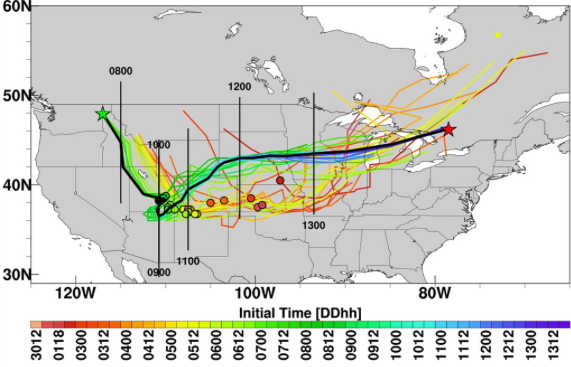

Citation: Weather and Forecasting 38, 10; 10.1175/WAF-D-22-0224.1

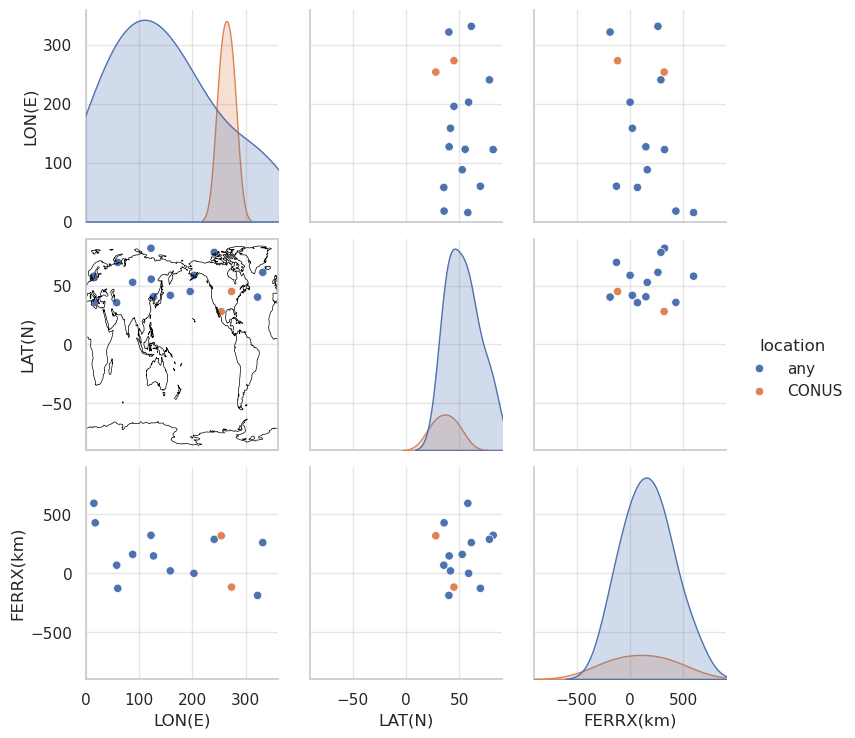

In [10]:
fp = sns.pairplot(
    df[(df["ITIME"] == itime) & (df["FHOUR"] >= 72) & (df["LAT(N)"] >= 0)],
    vars=["LON(E)", "LAT(N)", "FERRX(km)"],
    hue="location",
)
fix_axes(fp)

In [11]:
df[(df["ITIME"] == itime) & (df["FHOUR"] >= 72)].groupby("location").describe()["FERRX(km)"]

count        mean     min     25%     50%      75%     max  \
location                                                               
CONUS       2.0  101.110000 -116.94  -7.915  101.11  210.135  319.16   
any        15.0  101.837333 -417.30 -55.820   75.72  274.965  595.11   

                 std  
location              
CONUS     308.369267  
any       258.491108

In [12]:
df[df["FHOUR"] >= 72].groupby("location").describe()["FERRX(km)"]

count        mean      min       25%      50%     75%       max  \
location                                                                      
CONUS       428.0   71.357523 -3460.12 -182.5075   92.755  337.59   1885.37   
Lupo2023    197.0  577.132589  -428.73  291.5000  496.940  737.50   2045.63   
any       12705.0  -13.918678 -5860.40 -318.9200    0.000  296.29  10834.62   

                 std  
location              
CONUS     623.449350  
Lupo2023  484.250046  
any       762.520634

In [13]:
df[df["FHOUR"] >= 72].groupby("location").describe()["FERRX(km)"]

count        mean      min       25%      50%     75%       max  \
location                                                                      
CONUS       428.0   71.357523 -3460.12 -182.5075   92.755  337.59   1885.37   
Lupo2023    197.0  577.132589  -428.73  291.5000  496.940  737.50   2045.63   
any       12705.0  -13.918678 -5860.40 -318.9200    0.000  296.29  10834.62   

                 std  
location              
CONUS     623.449350  
Lupo2023  484.250046  
any       762.520634

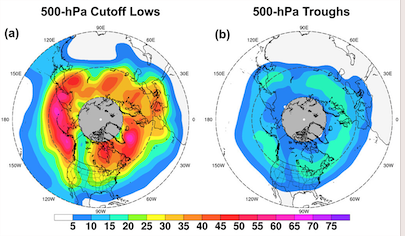

Citation: Weather and Forecasting 38, 10; 10.1175/WAF-D-22-0224.1

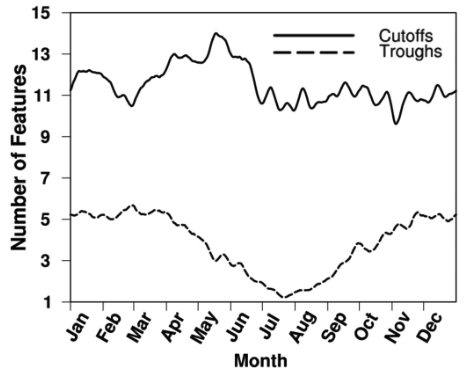

https://journals.ametsoc.org/view/journals/wefo/38/10/full-WAF-D-22-0224.1-f7.jpg

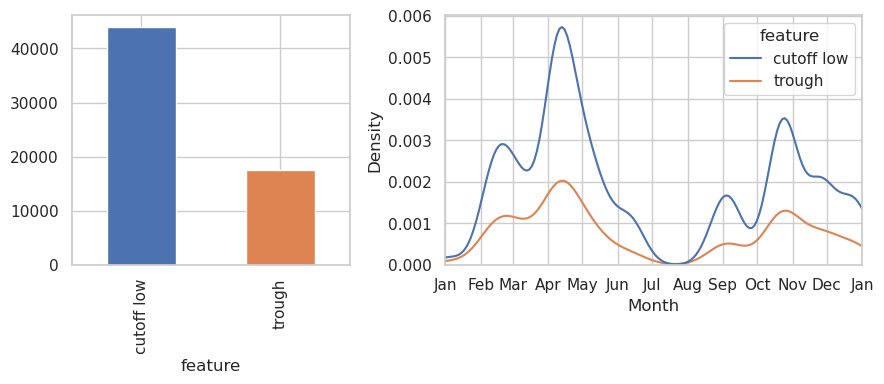

In [14]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

df["dayofyear"] = df["ITIME"].dt.dayofyear
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), width_ratios=[2, 3])
df["feature"].value_counts().plot(kind="bar", color=["C0", "C1"], ax=axes[0])
ax = axes[1]
ax = sns.kdeplot(df, x="dayofyear", hue="feature", ax=ax)
ax.set_xlabel("Month")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlim((0, 365))
plt.tight_layout()

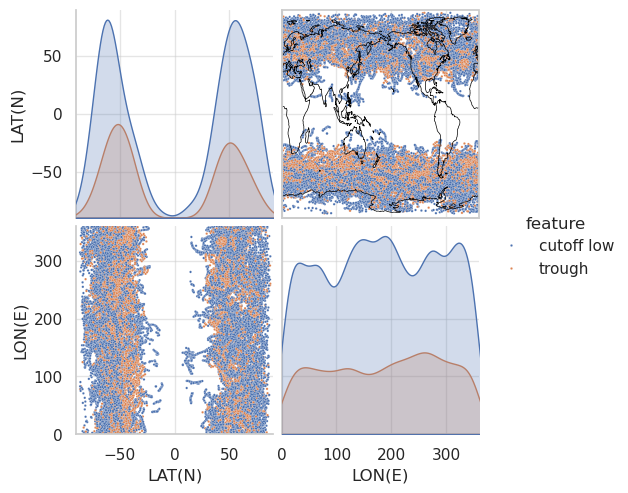

In [15]:
fp = sns.pairplot(
    df[(df["FHOUR"] >= 72)],
    vars=["LAT(N)", "LON(E)"],
    plot_kws={"s": 3},
    hue="feature",
)
fix_axes(fp)

## Divide NH zonal error into terciles (3 equal-sized groups based on value)

- high zonal error (progressive) most common over CONUS
- has greater meridional background slope

isForecast
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: Ro(km), dtype: object

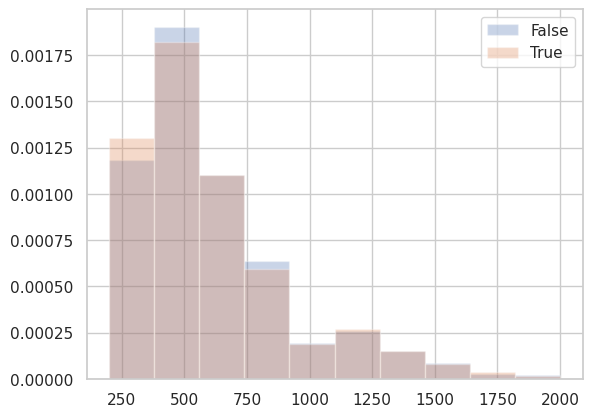

In [16]:
df["isForecast"] = df["FHOUR"] > 0
df.groupby("isForecast")["Ro(km)"].hist(density=True, alpha=0.3, legend=True)

isForecast
False    Axes(0.125,0.11;0.775x0.77)
True     Axes(0.125,0.11;0.775x0.77)
Name: T500(K), dtype: object

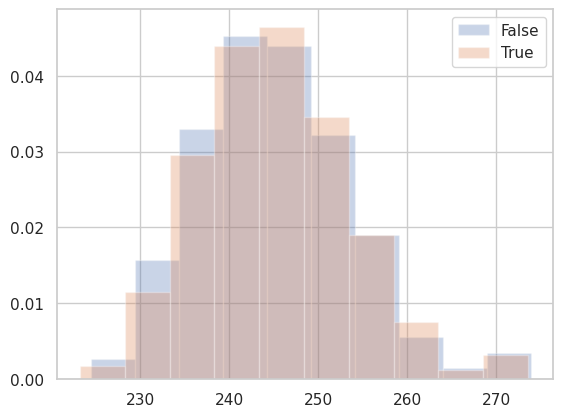

In [17]:
df.groupby("isForecast")["T500(K)"].hist(density=True, alpha=0.3, legend=True)

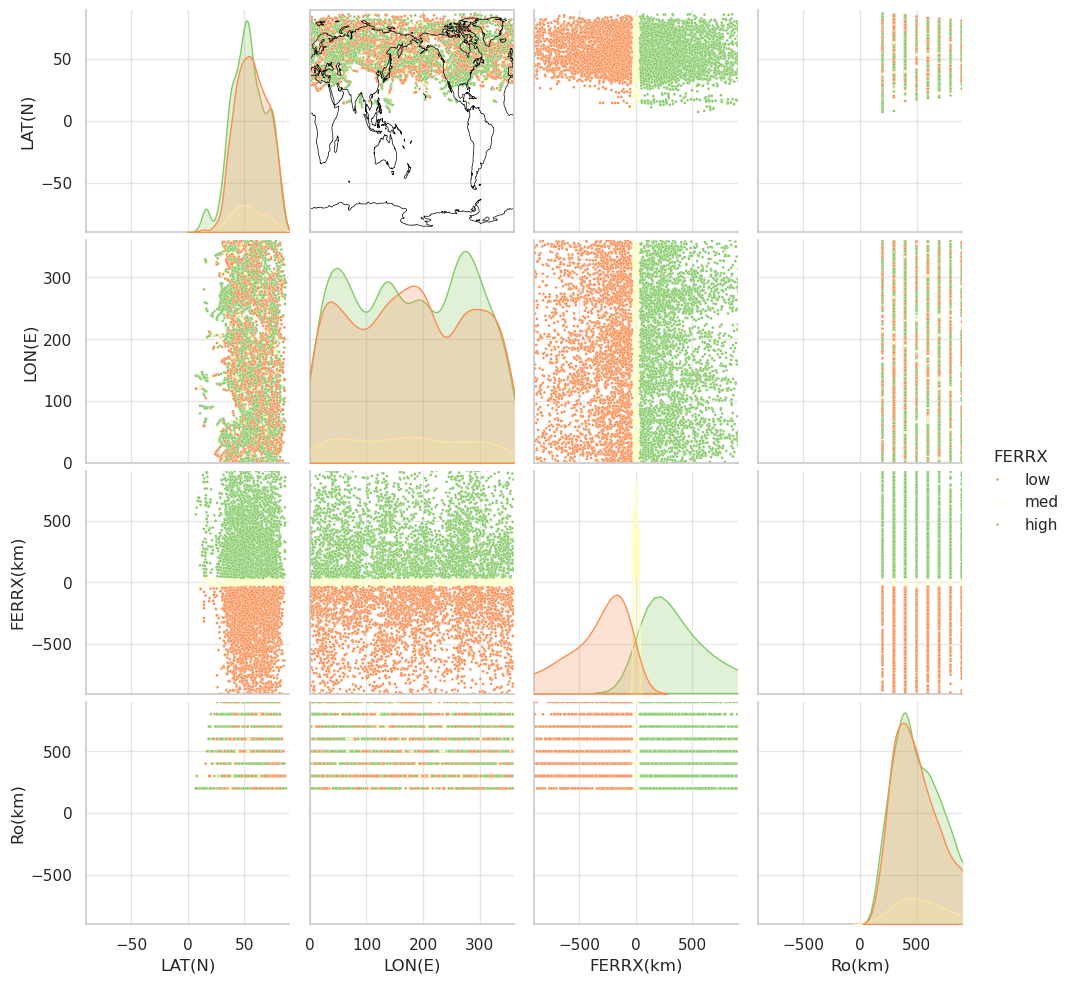

In [18]:
fp = sns.pairplot(
    df[
        (df["FHOUR"] >= 72)
        & (df["LAT(N)"] >= 0)
        # & (df["LAT(N)"] >= lat0)
        # & (df["LAT(N)"] < lat1)
        # & (df["LON(E)"] >= lon0)
        # & (df["LON(E)"] < lon1)
    ],
    vars=[
        "LAT(N)",
        "LON(E)",
        "FERRX(km)",
        #        "FERRY(km)",
        #        "BGo-lon(m/100km)",
        #        "BGo-lat(m/100km)",
        "Ro(km)",
    ],
    plot_kws={"s": 4},
    hue="FERRX",
    palette="RdYlGn",
)
fix_axes(fp)

In [19]:
df[df["FHOUR"] >= 72].describe().loc["mean"]

ITIME               2021-01-01 03:29:39.059456512
FHOUR                                  152.313691
ID                                   41244.663439
So(m/100km)                             18.233408
LAT(N)                                   1.557685
LON(E)                                 183.501629
SoFlag                                  -0.428626
Ro(km)                                 590.010989
SR                                        0.97651
BGo(m/100km)                            16.368753
BGo-lat(m/100km)                         1.779235
BGo-lon(m/100km)                         0.794555
ZMIN(m)                               5186.784187
ZLAT(N)                                  3.466459
ZLON(E)                                182.360647
Z850(m)                               1294.731145
Z500(m)                               5281.761957
Z200(m)                              11413.249176
T850(K)                                267.295293
T500(K)                                244.955451


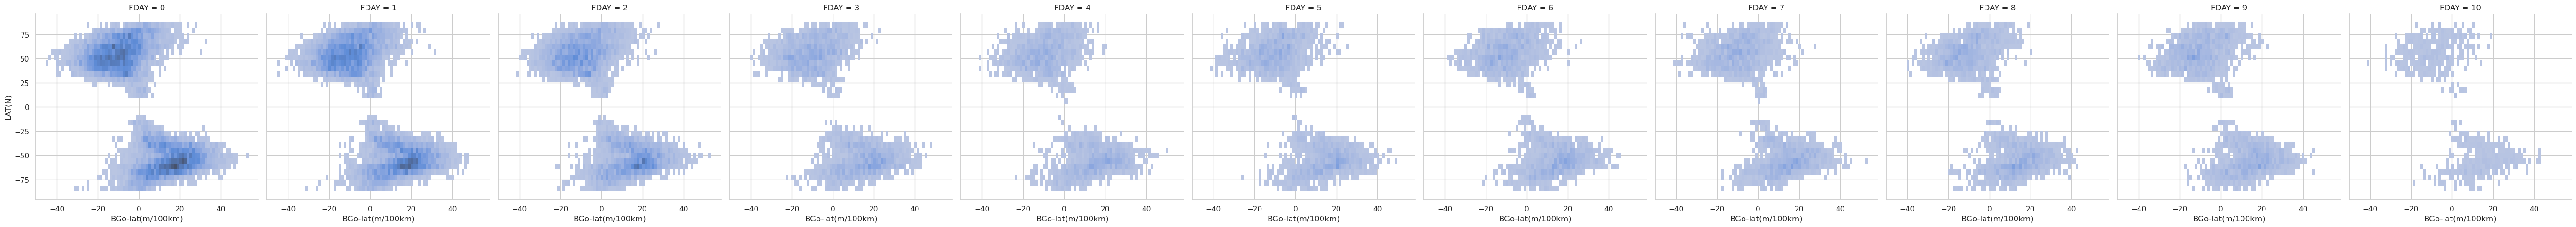

In [20]:
sns.displot(data=df, x="BGo-lat(m/100km)", y="LAT(N)", col="FDAY")

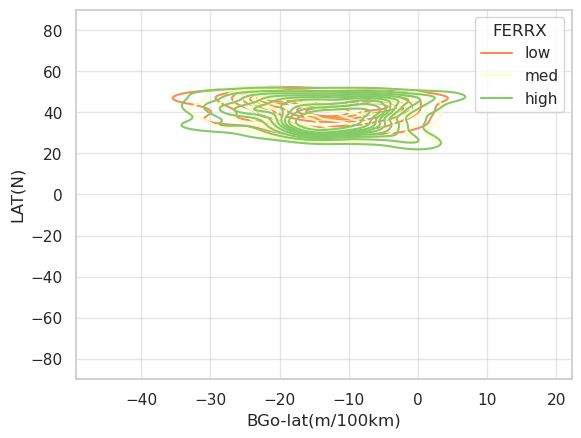

In [21]:
fix_axes(
    sns.kdeplot(
        data=df[df.location == "CONUS"],
        x="BGo-lat(m/100km)",
        y="LAT(N)",
        hue="FERRX",
        palette="RdYlGn",
    )
)

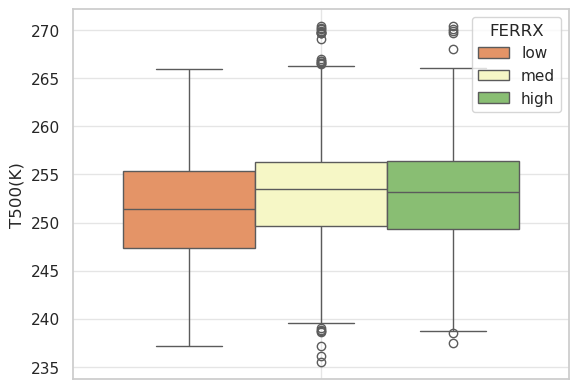

In [22]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="T500(K)",
    palette="RdYlGn",
)
fix_axes(fp)

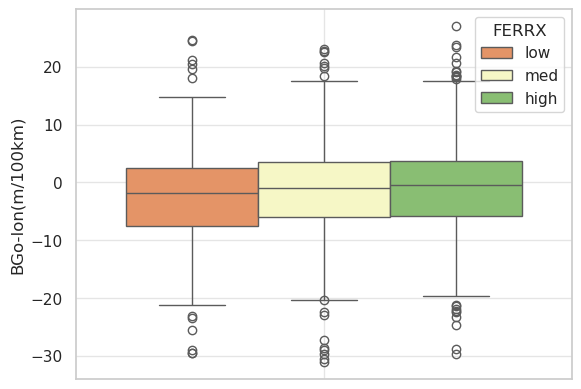

In [23]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="BGo-lon(m/100km)",
    palette="RdYlGn",
)
fix_axes(fp)

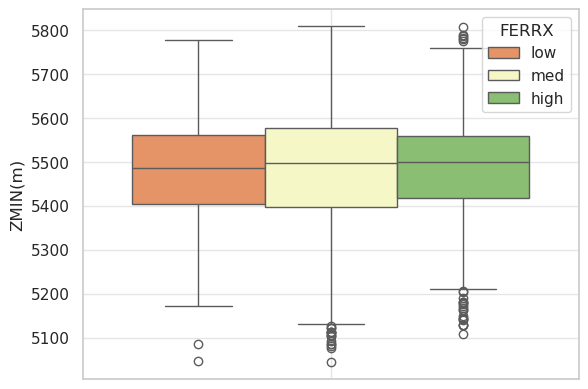

In [24]:
fp = sns.boxplot(
    data=df[df.location == "CONUS"],
    hue="FERRX",
    y="ZMIN(m)",
    palette="RdYlGn",
)
fix_axes(fp)

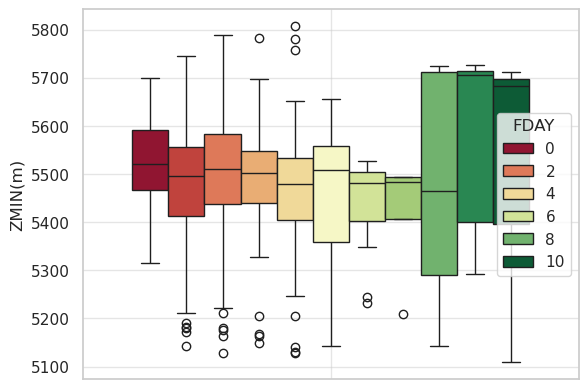

In [25]:
fp = sns.boxplot(
    data=df[(df.location == "CONUS") & (df.FERRX == "high")],
    hue="FDAY",
    y="ZMIN(m)",
    palette="RdYlGn",
)
fix_axes(fp)